# Анализ трат на топливо
## Описание проекта
Поиск инсайтов в процессе работы с данными.

**Цель** - проанализировать данные по тратам на топливо.

**Задачи:**

 * [X] выяснить сколько было потрачено денег на топливо
 * [X] какое топливо самое популярное
 * [X] какой средний расход топлива по месяцам и сколько это в стоимостном выражении

## Гипотезы
1. Среднее число литров газа при заправке больше, чем литров 95ого бензина.
2. Средняя цена топлива в соседних регионах совпадает с ценой в Оренбурге. 

## Описание данных
На руках имеются данные по заправкам на АЗС и АГЗС.

Размах - один год.

* `refueling_day` — день заправки;
* `type_of_fuel` — топливо, которое было заправлено;
* `price_per_liter` — цена за литр;
* `liters` — литров топлива заправлено;
* `odometer` - показания пробега машины.

## Содержание
 1. Откроем файл с данными и изучим общую информацию
 2. Предобработка данных
 3. Исследовательский анализ данных (EDA)
 4. Топливная карточка
 5. Проверка гипотез
 6. Выводы и рекомендации

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Памятка</h1>
✏️ По ходу проекта я буду писать комментарии("Мои размышления"). В них информация будет более развёрнутой. Там можно будет увидить что-то интересное.
    Такие комментарии я буду выделять так:
<div class="alert alert-info"><b>Мои размышления:</b> Дополнительная информация.</div>

# Откроем файл с данными и изучим общую информацию

In [45]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import datetime

In [2]:
# загрузим данные по заправкам топлива
data = pd.read_csv('/datasets/fuel_costs.csv', sep=',')

In [3]:
# посомотрим на датасет
data.sample(5, random_state = 0)

,refueling_day,type_of_fuel,price_per_liter,liters,odometer
26,2021-12-27T00:00:00,gas,26.70,37.94,216783
54,2022-02-27T00:00:00,gas,24.00,22.89,222620
37,2022-01-16T00:00:00,gas,26.70,31.30,219102
112,2022-06-21T00:00:00,95,48.38,3.11,235229
24,2021-12-20T00:00:00,95,48.38,20.67,216334


In [4]:
# посмотрим описание данных
data.describe()

,price_per_liter,liters,odometer
count,156.000000,156.000000,156.000000
mean,23.226282,28.909423,227771.525641
std,9.630283,8.390157,9819.794616
min,9.800000,3.110000,210930.000000
25%,19.300000,24.050000,219280.000000
50%,19.400000,30.775000,227167.500000
75%,25.150000,36.235000,236055.000000
max,50.400000,42.020000,245212.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   refueling_day    156 non-null    object 
 1   type_of_fuel     156 non-null    object 
 2   price_per_liter  156 non-null    float64
 3   liters           156 non-null    float64
 4   odometer         156 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 6.2+ KB


In [6]:
# доля пропусков
data.isna().mean()

refueling_day      0.0
type_of_fuel       0.0
price_per_liter    0.0
liters             0.0
odometer           0.0
dtype: float64

In [7]:
# доля явных дубликатов
data.duplicated().mean()

0.0

In [8]:
# уникальные виды топлива
data['type_of_fuel'].unique()

array(['gas', '95', '92'], dtype=object)

In [9]:
# мин-макс цена газа
data.query('type_of_fuel == "gas"')['price_per_liter'].agg({'min', 'max'})

max    26.7
min     9.8
Name: price_per_liter, dtype: float64

In [10]:
# мин-макс цена 95ого
data.query('type_of_fuel == "95"')['price_per_liter'].agg({'min', 'max'})

max    50.40
min    46.78
Name: price_per_liter, dtype: float64

In [11]:
# мин-макс цена 92ого
data.query('type_of_fuel == "92"')['price_per_liter'].agg({'min', 'max'})

max    47.00
min    44.46
Name: price_per_liter, dtype: float64

In [12]:
# общая информация
total_visits = len(data) 
print(f'Количество заездов на ЗС: {total_visits}')
print(f'Размах данных:', data['refueling_day'].min(), data['refueling_day'].max())
print(data['type_of_fuel'].value_counts().sort_values(ascending=False).head(10))

Количество заездов на ЗС: 156
Размах данных: 2021-10-19T00:00:00 2022-10-12T00:00:00
gas    140
95      14
92       2
Name: type_of_fuel, dtype: int64


**Что по данным видно:**
 * Из хорошего:
   * [X] название столбцов не в `CamelCase` стиле(что логично, ведь я это просчитал на моменте сбора данных😎);
   * [X] типы данных столбцов про: тип топлива, цены за литр, кол-во литров и показания пробега - меня вполне устраивают и число знаков после "запятой" подходящее;
   * [X] число записей в столбцах одинаково;
   * [X] доля пропусков 0;
   * [X] доля явных дубликатов 0.
 * Из плохого:
   * [X] неверный тип данных столбца `refueling_day`(нужен `datetime`, а не `object`)

**Конкретика по данным:**
 * первая запись - 2021-10-19;
 * последняя запись - 2022-10-12;
 * число заправок топливом - 156;
 * видов топлива - 3('gas', '95', '92');
 * Цена на топливо :
  * Газ :
    * Минимум - 9.80;
    * Максимум - 26.70.
  * 95:
    * Минимум - 46.78;
    * Максимум - 50.40.
  * 92:
    * Минимум - 44.46;
    * Максимум - 47.00

# Предобработка данных

In [13]:
# меняем тип данных
data['refueling_day'] = pd.to_datetime(data['refueling_day'], format='%Y-%m-%dT%H:%M:%S')

In [14]:
# создание нового столбца "cost", округляем значения до 2 знаков после запятой
data['cost'] = round((data['price_per_liter'] * data['liters']).astype('float'), 2)

In [15]:
# выделим месяц
data['month'] = data['refueling_day'].astype('datetime64[M]')

In [16]:
# датасет после добавления нового столбца
data.sample(5, random_state = 0)

,refueling_day,type_of_fuel,price_per_liter,liters,odometer,cost,month
26,2021-12-27,gas,26.70,37.94,216783,1013.00,2021-12-01
54,2022-02-27,gas,24.00,22.89,222620,549.36,2022-02-01
37,2022-01-16,gas,26.70,31.30,219102,835.71,2022-01-01
112,2022-06-21,95,48.38,3.11,235229,150.46,2022-06-01
24,2021-12-20,95,48.38,20.67,216334,1000.01,2021-12-01


# Исследовательский анализ данных (EDA)

In [46]:
fig = px.line(data, 
              x="refueling_day", 
              y="price_per_liter", 
              color="type_of_fuel", 
              labels={"price_per_liter":"Цена за литр", "refueling_day": "Дата", "type_of_fuel":"Тип топлива"},
              markers=True)
fig.show()

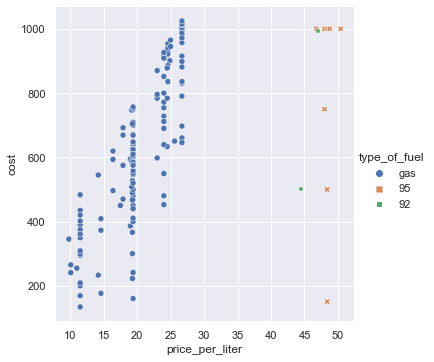

In [23]:
# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=data,
    x="price_per_liter", y="cost", 
    hue="type_of_fuel", style="type_of_fuel",
)

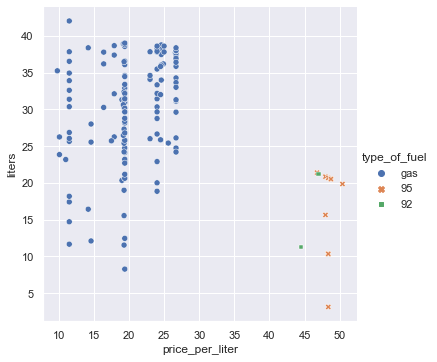

In [24]:
# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=data,
    x="price_per_liter", y="liters",
    hue="type_of_fuel", style="type_of_fuel",
)

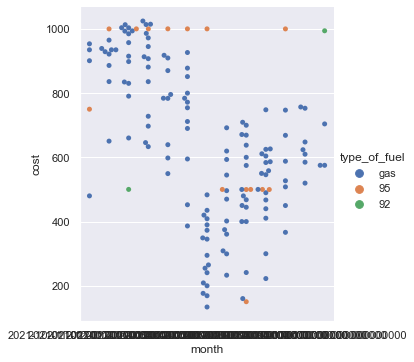

In [27]:
sns.catplot(data=data, kind="swarm", x="month", y="cost", hue="type_of_fuel")

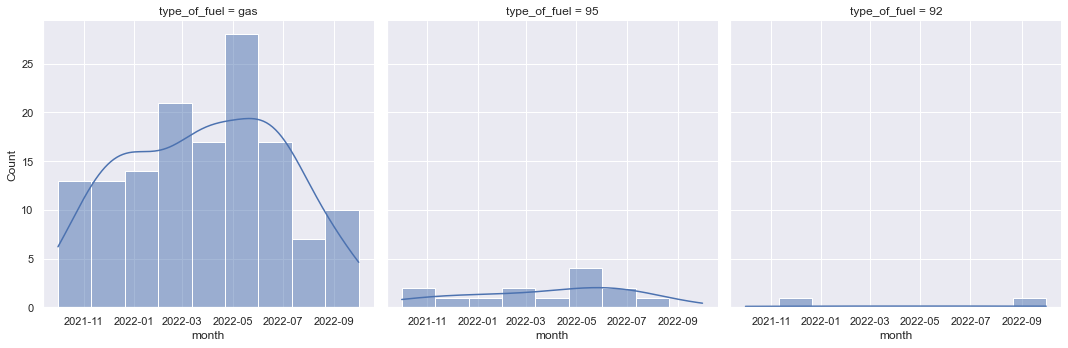

In [26]:
sns.displot(data=data, x="month", col="type_of_fuel", kde=True)

<AxesSubplot:xlabel='liters', ylabel='type_of_fuel'>

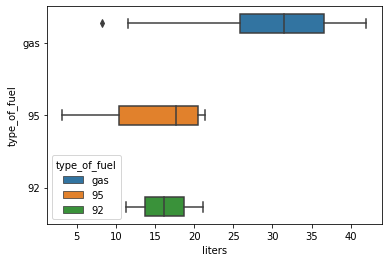

In [17]:
# посмотрим какой объём заправки характерен для разных типов топлива
sns.boxplot(data=data, x = 'liters', y = 'type_of_fuel', hue = 'type_of_fuel')

# Топливная карточка

## Cколько было потрачено денег на топливо?

За 12 месяцев:
Потрачено на газ - 88512.02 р.
Потрачено на 95 бензин - 10400.19 р.
Потрачено на 92 бензин - 1494.23 р.

Всего потрачено на топливо - 100406.44 р.


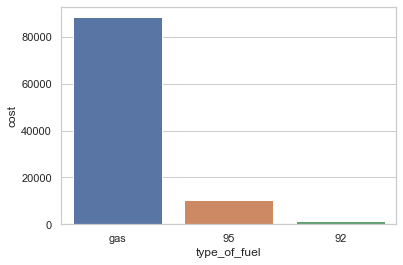

In [28]:
tc = data.groupby('type_of_fuel').agg({'cost': 'sum'}).reset_index().sort_values(by='cost', ascending=False)

with sns.axes_style("whitegrid"):
    sns.barplot(x=tc["type_of_fuel"], y=tc["cost"])
    
print('За 12 месяцев:')
print(f'Потрачено на газ -', round(data.query('type_of_fuel == "gas"')['cost'].sum(), 2), 'р.')
print(f'Потрачено на 95 бензин -', round(data.query('type_of_fuel == "95"')['cost'].sum(), 2), 'р.')
print(f'Потрачено на 92 бензин -', round(data.query('type_of_fuel == "92"')['cost'].sum(), 2), 'р.')
print()
print(f'Всего потрачено на топливо -', round(data['cost'].sum(), 2), 'р.')

## Какое топливо самое популярное?

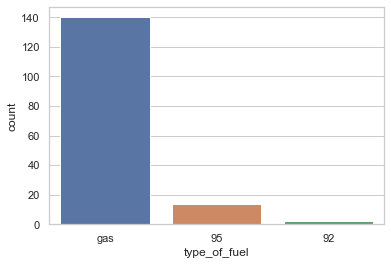

In [29]:
# виды заправляемого топлива, их частота
with sns.axes_style("whitegrid"):
    sns.countplot(data=data, x='type_of_fuel')

**Топ топлива:**
 - 1) Газ, 140 заправок данным видом топлива;
 - 2) 95 бензин, 14 заправок данным видом топлива;
 - 3) 92 бензин, 2 заправки данным видом топлива.

## Какой расход топлива по месяцам и сколько это в стоимостном выражении?

In [34]:
# подготовим переменную
mc = data.groupby(['type_of_fuel', 'month']).agg({'liters': 'sum', 'cost':'sum'}).reset_index()

In [40]:
# построим график по "mc"
fig = px.bar(mc, x='month', y='liters', color='type_of_fuel', labels={'month':'Месяц', 'liters':'Литров'})
fig.show()